In [1]:
# Function for generating histogram
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot

importing Jupyter notebook from histplot.ipynb
644
3122


In [2]:
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [3]:
# Summer 2018 as an example
Summer18 = histplot.getData(18, direct, ASC, 152, 92, 6 , float)


In [4]:
def calc(precip_data, what_bin):
    hist, bin_edge = np.histogram(precip_data, bins = what_bin)
    log_y = np.log(hist)
    bin_val = np.zeros(len(what_bin)-1)
    for i in range(len(what_bin)-1):
        bin_val[i] = (what_bin[i] + what_bin[i+1])/2
    logx = np.log(bin_val)
    curve_fit = np.polyfit(logx, log_y,1)
    curve_fit[1] = np.exp(curve_fit[1])
    return curve_fit, bin_val

In [31]:
# Exponentials get from durations
def exponential(in_put, exclude):
    first_bin = np.zeros(50)
    for i in range(0, 50):    
        first_bin[i] = np.percentile(in_put, i*2)
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals
    

In [32]:
# Exponentials get from intensity
def exponential_int(in_put, exclude):
    first_bin = np.zeros(50)
    for i in range(0, 50):    
        first_bin[i] = np.round(np.percentile(in_put, i*2),2)
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals

In [74]:
def counting(data, want):
    counts = 0
    newdata = data[data < want]
    counts = len(newdata)
    return counts

In [98]:
def model_1(data, amount, howmuch):
    precip, nonprecip, preciptotal, totalprep = histplot.preciphist(data, len(data), amount, 1, 1)
    count = 0
    count1 = 0
    for i in range(0, len(precip)):
        hold = precip[i]
        hold1 = nonprecip[i]
        if hold > 0:
            count += 1
        if hold1 > 0:
            count1 += 1
    precip = precip[:count]
    nonprecip = nonprecip[:count1]
    preciptotal = preciptotal[:count]
    # Calculate intensities 
    inten = np.divide(preciptotal, precip)
    #(inten)
    # Exponentials for precipitation duration 
    pre_exp,pre_f_bins, bin_vals = exponential(precip, 1)
    # Exponentials for nonprecipitation duration 
    non_pre, nonpre_f_bins, nonp_b_vals = exponential(nonprecip, 1)
    # Exponentials for Intensity of Precipitation duration
    intensity, inten_f_bins, inten_b_vals = exponential_int(inten, 0.01)
    # print(nonpre_f_bins)
    # Construct intervals and probabilities for precipitation durations
    Pre_prob = np.zeros(1)
    pre_bin_1 = counting(precip, pre_f_bins[0])
    Pre_prob[0] = pre_bin_1
    construct_1 = pre_exp[1]*np.exp(np.log(bin_vals)*pre_exp[0])
    Pre_prob = np.append(Pre_prob, construct_1)
    Pre_prob = Pre_prob/sum(Pre_prob)
    # Non_precipitation duration probs
    NonPre_prob = np.zeros(1)
    nonpre_bin_1 = counting(nonprecip, nonpre_f_bins[0])
    NonPre_prob[0] = nonpre_bin_1
    construct_2 = non_pre[1]*np.exp(np.log(nonp_b_vals)*non_pre[0])
    NonPre_prob = np.append(NonPre_prob, construct_2)
    NonPre_prob = NonPre_prob/sum(NonPre_prob)
    # Intensity probs
    Intensity_prob = np.zeros(1)
    inten_bin_1 = counting(inten, inten_f_bins[0])
    Intensity_prob[0] = inten_bin_1
    construct_3 = intensity[1]*np.exp(np.log(inten_b_vals)*intensity[0])
    Intensity_prob = np.append(Intensity_prob, construct_3)
    Intensity_prob = Intensity_prob/sum(Intensity_prob)
    # Precipitation intervals
    Pre_interval = [1]
    Pre_interval = np.append(Pre_interval, pre_f_bins)
    # NonPrecipitation intervals
    NonPre_interval = [1]
    NonPre_interval = np.append(NonPre_interval, nonpre_f_bins)
    # Intensity intervals
    Intensity_interval = [0.01]
    Intensity_interval = np.append(Intensity_interval, inten_f_bins)
    Model_outputs = 0;
    # Running the crude model
    for i in range(howmuch):
        minutes = 0;
        Model = np.zeros(len(data))
        start = np.random.randint(0, 1)
        while (len(data)-1 > minutes):
            # run probability of precipitation event duration
            pre_index = np.random.choice(np.arange(len(Pre_prob)), p = Pre_prob)
            pre_duration = np.random.randint(Pre_interval[pre_index], Pre_interval[pre_index + 1]+1)
            # run probability of precipitation event intensity
            inten_index = np.random.choice(np.arange(len(Intensity_prob)), p = Intensity_prob)
            model_intensity = 0.01*np.random.randint(100*Intensity_interval[inten_index], 100*Intensity_interval[inten_index+1]+1)
            # run probability of non-precipitation event duration
            nonpre_index = np.random.choice(np.arange(len(NonPre_prob)), p = NonPre_prob) 
            nonpre_duration = np.random.randint(NonPre_interval[nonpre_index], NonPre_interval[nonpre_index + 1]+1)
            # Nonprecipitation starts first
            if start == 0: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                else: 
                    if (len(data) < minutes + nonpre_duration):
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
                    elif (len(data) < minutes + nonpre_duration + pre_duration):
                        for j in range(nonpre_duration):
                            Model[minutes] = 0
                            minutes += 1
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
            # Precipitation starts first
            if start == 1: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                else: 
                    if (len(data) < minutes + pre_duration):
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
                    elif (len(data) < minutes + pre_duration + nonpre_duration):
                        for k in range(pre_duration):
                            Model[minutes] = model_intensity
                            minutes += 1
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
        Model_outputs = Model
    return Model_outputs, data 

In [99]:
sample_output, compare_data = model_1(Summer18, 5000, 1)

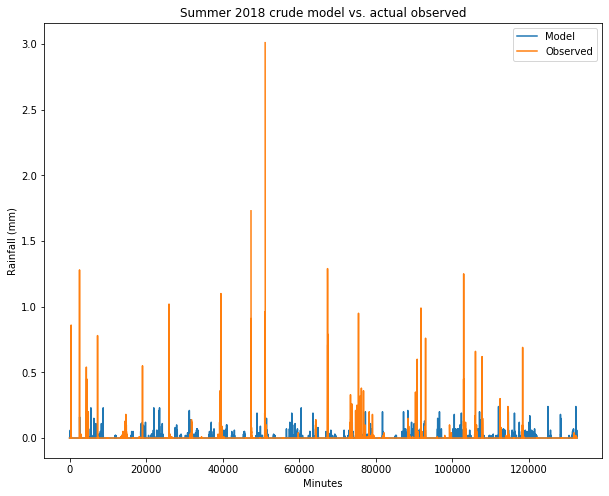

In [108]:
plt.figure(figsize = (10, 8))
plt.plot(sample_output)
plt.plot(compare_data)
plt.title('Summer 2018 crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'])